# Cross validation of the Intravoxel incoherent motion (ivim) model in Dipy

Models need to have a `fit` and `predict` method defined.

## Ivim model

The IVIM model expresses the MRI signal as follows:

$$ S(b)=S_0(fe^{-bD^*}+(1-f)e^{-bD}) $$

where $\mathbf{b}$ is the diffusion gradient weighing value (which is dependent on the measurement parameters), $\mathbf{S_{0}}$ is the signal in the absence of diffusion gradient sensitization, $\mathbf{f}$ is the perfusion fraction, $\mathbf{D}$ is the diffusion coefficient and $\mathbf{D^*}$ is the pseudo-diffusion constant, due to vascular contributions.

We want to compare the performace of this model with other models such as a simple exponential decay.

The signal is recorded for many `b-values` at each point (voxel). Thus we have an array of signal values S(b) for each voxel. After we fit the data from each voxel and get the model parameters we would like to see how well the predictions match with the actual values. We will split our dataset to perform "leave-one-out cross validation" or "n-cross validation" on b-values. We leave out one b value and fit our model. Then we predict the values of the volume at the left out b value.

In [1]:
import numpy as np

from dipy.reconst.ivim import IvimModel
from dipy.data.fetcher import read_ivim
import dipy.core.gradients as dpg
from dipy.reconst.base import ReconstModel
from dipy.reconst.multi_voxel import multi_voxel_fit

from cv import *
import csv   


import matplotlib.pyplot as plt
% matplotlib inline

# Downloading the data and selecting a small slice for testing

The dataset supplied here is from Eric Peterson [share](https://figshare.com/articles/IVIM_dataset/3395704). It has MRI signal data for a 3D region (brain) where each voxel will have its own parameters (S0, f, D and D_star). Dipy has a `fetcher` to download the ivim data.

In [2]:
img, gtab = read_ivim()
data = img.get_data()

print('data.shape (%d, %d, %d, %d)' % data.shape)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/shahnawaz/.dipy/ivim 
data.shape (256, 256, 54, 21)


In [3]:
z = 33
x1, x2 = 90, 150
y1, y2 = 90, 180

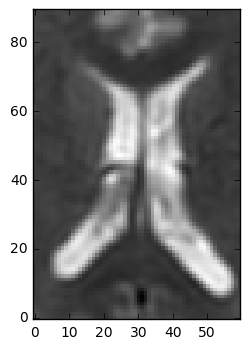

In [4]:
# Plot at b=0
b_val = 0
plt.imshow(data[x1:x2, y1:y2, z, b_val].T, origin='lower',
           cmap="gray", interpolation='nearest')
plt.show("CSF_slice.png")
plt.close()

# Define an error metric (nmse)

In [68]:
def nmse(data, prediction):
    """
    Compute the normalized mean squared error.
    """
    return (((data - prediction)**2).mean())/sum(data**2)

def leave_one_cross(model, data_slice, gtab):
    """
    Performs a leave one out cross validation and returns the prediction and normalised mean sq error
    """
    # Preallocate an array for the results:
    predictions = np.zeros([data_slice.shape[0], 
                            data_slice.shape[1],
                            data_slice.shape[2],
                            data_slice.shape[3] - 1])

    # Normalized mean sq error
    NMSE = []
    # Note that we are not predicting S0, because we always need S0 to fit the model

    for left_out in range(1, data_slice.shape[-1]-1):
        # These are the b-values/b-vectors with one of them left out:
        left_out_bvals = np.concatenate([gtab.bvals[:left_out], gtab.bvals[left_out+1:]])
        left_out_bvecs = np.concatenate([gtab.bvecs[:left_out], gtab.bvecs[left_out+1:]])
        left_out_gtab = dpg.gradient_table(left_out_bvals, left_out_bvecs)
        # Create a model for this iteration
        current_model = model(left_out_gtab)
        # We fit to the data leaving out the current measurement
        left_out_data = np.concatenate([data_slice[..., :left_out], 
                                        data_slice[..., left_out+1:]], -1)
        fit = current_model.fit(left_out_data)
        # We try to predict only the left out measurement
        predict_gtab = dpg.gradient_table(np.array([gtab.bvals[left_out]]), 
                                          np.array([gtab.bvecs[left_out]]))
        left_predictions = fit.predict(predict_gtab)
        predictions[..., left_out] = left_predictions[..., 0]
        err = nmse(left_predictions.squeeze().ravel(), data_slice[..., left_out].squeeze().ravel())
        NMSE += [err]
        

    return (predictions, np.array(NMSE))

# max values for each dim
x, y, z, bval = data.shape
vol_size = 1
# Select random volumes for cross validation

In [69]:
for i in range(1):
    x1, y1, z1 = [np.random.randint(foo) for foo in [x-vol_size, y - vol_size, z- vol_size]]
    x2, y2, z2 = x1 + vol_size, y2 + vol_size, z1+ vol_size

    data_slice = data[x1:x2, y1:y2, z1:z2, :]
    ivim_predictions, ivim_nmse = leave_one_cross(IvimModel, data_slice, gtab)

    out = [x1, y1, z1]
    out.append(ivim_nmse.mean())
    
#     nmse_flat = ivim_nmse.ravel()
#     for x in nmse_flat:
#         out.append(x)

    with open('ivim'+'.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(out)
    
    exp_predictions, exp_nmse = leave_one_cross(ExponentialModel, data_slice, gtab)
    out = [x1, y1, z1]
    out.append(exp_nmse.mean())

    with open('exp'+'.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(out)

/Users/shahnawaz/dev/dipy/dipy/reconst/ivim.py:404: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/Users/shahnawaz/dev/dipy/dipy/reconst/ivim.py:498: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/Users/shahnawaz/dev/dipy/dipy/reconst/ivim.py:293: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


# Making your own estimator

We used the `IvimModel` for cross validation and will build our custom models to check if it performs better. Let us build a simple estimator which predicts parameters for an exponential decay model.

$$ y = S_{0} e^{-D x}$$

In the file `cv.py` we have the `ExponentialModel` to do this comparision.